int64
object
20     1079
60      575
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64
    MSSubClass_120  MSSubClass_150  MSSubClass_160  MSSubClass_180  \
Id                                                                   
1                0               0               0               0   
2                0               0               0               0   
3                0               0               0               0   
4                0               0               0               0   
5                0               0               0               0   

    MSSubClass_190  MSSubClass_20  MSSubClass_30  MSSubClass_40  \
Id                                                                
1                0              0              0              0   
2                0              1              0              0   
3    

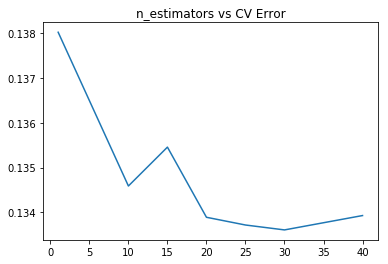

     Id      SalePrice
0  1461  113826.670868
1  1462  153896.305481
2  1463  172098.539726
3  1464  197498.870753
4  1465  195636.126181
5  1466  169929.793646
6  1467  185551.359943
7  1468  163722.764334
8  1469  188965.434507
9  1470  121630.828275


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor


# step1 检查源数据集，读入数据，将csv数据转换为DataFrame数据
train_df = pd.read_csv('C:/Users/Administrator/Desktop/train.csv',index_col = 0)
test_df = pd.read_csv('C:/Users/Administrator/Desktop/test.csv',index_col = 0)
# print train_df.shape
# print test_df.shape
# print train_df.head()  # 默认展示前五行 这里是5行,80列
# print test_df.head()   # 这里是5行,79列

# step2 合并数据，进行数据预处理
prices = pd.DataFrame({'price':train_df['SalePrice'],'log(price+1)':np.log1p(train_df['SalePrice'])})
# ps = prices.hist()
# plt.plot()
# plt.show()

y_train = np.log1p(train_df.pop('SalePrice'))
all_df = pd.concat((train_df,test_df),axis = 0)
# print all_df.shape
# print y_train.head()

# step3 变量转化
print (all_df['MSSubClass'].dtypes)
all_df['MSSubClass'] = all_df['MSSubClass'].astype(str)
print (all_df['MSSubClass'].dtypes)
print (all_df['MSSubClass'].value_counts())
# 把category的变量转变成numerical表达形式
# get_dummies方法可以帮你一键one-hot
print (pd.get_dummies(all_df['MSSubClass'],prefix = 'MSSubClass').head())
all_dummy_df = pd.get_dummies(all_df)
print (all_dummy_df.head())

# 处理好numerical变量
print (all_dummy_df.isnull().sum().sort_values(ascending = False).head(11))
# 我们这里用mean填充
mean_cols = all_dummy_df.mean()
print (mean_cols.head(10))
all_dummy_df = all_dummy_df.fillna(mean_cols)
print (all_dummy_df.isnull().sum().sum())

# 标准化numerical数据
numeric_cols = all_df.columns[all_df.dtypes != 'object']
print (numeric_cols)
numeric_col_means = all_dummy_df.loc[:,numeric_cols].mean()
numeric_col_std = all_dummy_df.loc[:,numeric_cols].std()
all_dummy_df.loc[:,numeric_cols] = (all_dummy_df.loc[:,numeric_cols] - numeric_col_means) / numeric_col_std

# step4 建立模型
# 把数据处理之后，送回训练集和测试集
dummy_train_df = all_dummy_df.loc[train_df.index]
dummy_test_df = all_dummy_df.loc[test_df.index]
print (dummy_train_df.shape,dummy_test_df.shape)

# 将DF数据转换成Numpy Array的形式，更好地配合sklearn

X_train = dummy_train_df.values
X_test = dummy_test_df.values

# Ridge Regression
# alphas = np.logspace(-3,2,50)
# test_scores = []
# for alpha in alphas:
#   clf = Ridge(alpha)
#   test_score = np.sqrt(-cross_val_score(clf,X_train,y_train,cv = 10,scoring = 'neg_mean_squared_error'))
#   test_scores.append(np.mean(test_score))
# plt.plot(alphas,test_scores)
# plt.title('Alpha vs CV Error')
# plt.show()

# random forest
# max_features = [.1,.3,.5,.7,.9,.99]
# test_scores = []
# for max_feat in max_features:
#   clf = RandomForestRegressor(n_estimators = 200,max_features = max_feat)
#   test_score = np.sqrt(-cross_val_score(clf,X_train,y_train,cv = 5,scoring = 'neg_mean_squared_error'))
#   test_scores.append(np.mean(test_score))
# plt.plot(max_features,test_scores)
# plt.title('Max Features vs CV Error')
# plt.show()

# ensemble
# 用stacking的思维来汲取两种或者多种模型的优点

# ridge = Ridge(alpha = 15)
# rf = RandomForestRegressor(n_estimators = 500,max_features = .3)
# ridge.fit(X_train,y_train)
# rf.fit(X_train,y_train)
# y_ridge = np.expm1(ridge.predict(X_test))
# y_rf = np.expm1(rf.predict(X_test))
# y_final = (y_ridge + y_rf) / 2

# 做一点高级的ensemble
#ridge = Ridge(alpha = 15)
# bagging 把很多小的分类器放在一起，每个train随机的一部分数据，然后把它们的最终结果综合起来（多数投票）
# bagging 算是一种算法框架
#params = [1,10,15,20,25,30,40]
#test_scores = []
#for param in params:
    #clf = BaggingRegressor(base_estimator = ridge,n_estimators = param)
    #test_score = np.sqrt(-cross_val_score(clf,X_train,y_train,cv = 10,scoring = 'neg_mean_squared_error'))
    #test_scores.append(np.mean(test_score))
#plt.plot(params,test_scores)
#plt.title('n_estimators vs CV Error')
#plt.show()

#br = BaggingRegressor(base_estimator = ridge,n_estimators = 25)
#br.fit(X_train,y_train)
#y_final = np.expm1(br.predict(X_test))

# boosting 比bagging更高级，它是弄来一把分类器，把它们线性排列，下一个分类器把上一个分类器分类不好的地方加上更高的权重，这样，下一个分类器在这部分就能学习得更深刻
params = [10,15,20,25,30,35,40,45,50]
test_scores = []
for param in params:
    clf = AdaBoostRegressor(base_estimator = ridge,n_estimators = param)
    test_score = np.sqrt(-cross_val_score(clf,X_train,y_train,cv = 10,scoring = 'neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
plt.plot(params,test_scores)
plt.title('n_estimators vs CV Error')
plt.show()


# 提交结果
submission_df = pd.DataFrame(data = {'Id':test_df.index,'SalePrice':y_final})
print (submission_df.head(10))
submission_df.to_csv('C:/Users/Administrator/Desktop/submission_bagging.csv',columns = ['Id','SalePrice'],index = False)